# SVM for fact based news classification

In [151]:
import pandas as pd 
import string
import re 
import nltk

import numpy
import time
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from textblob import TextBlob 

from textblob import TextBlob


# Load Data

In [143]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
#read in manually laballed dataset
dataset = pd.read_csv('/content/drive/MyDrive/datasets/fact_opinion_dataset.csv', encoding='cp1252')
dataset = dataset.dropna()


dataset['sentiment'] = dataset['Text'].apply(lambda text: TextBlob(text).sentiment[1])
dataset['y'] = np.where(dataset['Label']== 'Opinion', 1, 0)
dataset['subjectivity'] = np.where(dataset['sentiment'] <= 0.42, 0, 1)

### Confusion matrix

In [153]:
def make_confusion_matrix(cf, group_names=None, categories='auto', count=True, percent=True, cbar=True, xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('conf.pdf')  

    if title:
        plt.title(title)
        

In [154]:
def clean(text):
    # removing all the characters other than alphabets
    cleaned_text_1= re.sub("[^a-zA-Z]", " ", text)
    cleaned_text_2 = re.sub(r'\W+', ' ', cleaned_text_1)
    # converting text to lower case
    cleaned_text = re.sub("\d+", " ", cleaned_text_2)
    cleaned_text= cleaned_text.lower()

    return cleaned_text

# Now creating a separate column which contains the above function applied to "text" column
dataset['clean'] = dataset["Text"].apply(lambda x : clean(x))

### Hyperparameter tunning

In [155]:
# Define x and y train and test set
text = dataset['clean'].tolist()
labels = dataset['y'].tolist()

train_texts, test_texts, train_labels, test_labels = train_test_split(text, labels, test_size=.2)

x_train = train_texts
x_test = test_texts
y_train = train_labels
y_test = test_labels

# classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1,1))),
    ('clf', svm.SVC(kernel='linear',C=1.9, gamma='auto')),
])

parameters = {
    'tfidf__max_features': (3600,10000)
}

f1_scorer = make_scorer(f1_score, average='micro', pos_label="fake")

# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=10 , verbose=1,scoring=f1_scorer)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
t0 = time.time()
grid_search.fit(x_train, y_train)
print("done in %0.3fs" % (time.time() - t0))
print()
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(x_test)
print("micro F1 score: " + str(f1_score(y_test, predictions, average='micro')))

Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_features': (3600, 10000)}
Fitting 10 folds for each of 2 candidates, totalling 20 fits
done in 0.613s

Best score: 0.860
Best parameters set:
	tfidf__max_features: 3600
micro F1 score: 0.8181818181818182


### Train and evaluate model

micro F1-score: 0.8181818181818182
macro F1-score: 0.8166666666666668
Precision: 0.800
Recall: 0.800
Accuracy: 0.818
F1 Score: 0.800


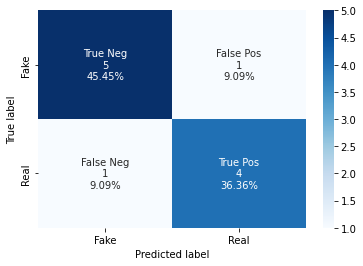

In [156]:
Tfidf_vect = TfidfVectorizer(max_features=3600, min_df=2, max_df=0.5, ngram_range=(1,1))

Tfidf_vect.fit(x_train)
train_x_tfidf = Tfidf_vect.transform(x_train)
test_x_tfidf = Tfidf_vect.transform(x_test)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake', 'Real']

# Classifier - Support Vector Machine
SVM = svm.SVC(C=1.9, kernel='linear')
SVM.fit(train_x_tfidf, y_train)
svm_predictions = SVM.predict(test_x_tfidf)
svm_cf_matrix = confusion_matrix(y_test, svm_predictions)

make_confusion_matrix(svm_cf_matrix, group_names=labels, categories=categories, cmap='Blues')
print("micro F1-score: " + str(f1_score(y_test, svm_predictions, average='micro')))
print("macro F1-score: " + str(f1_score(y_test, svm_predictions, average='macro')))

	
print('Precision: %.3f' % precision_score(y_test, svm_predictions))
print('Recall: %.3f' % recall_score(y_test, svm_predictions))
print('Accuracy: %.3f' % accuracy_score(y_test, svm_predictions))
print('F1 Score: %.3f' % f1_score(y_test, svm_predictions))



### Saving model

In [157]:
# filepath="/content/drive/MyDrive/saves/factvsopi_model.pkl"

# Save model
# pkl.dump(SVM, open(filepath, 'wb'))

### Load and Test model

In [158]:
filepath="/content/drive/MyDrive/saves/factvsopi_model.pkl"

# Load saved model
# SVM_model = pd.read_pickle(filepath)
result = SVM.predict(test_x_tfidf)

print('Precision: %.3f' % precision_score(y_test, result))
print('Recall: %.3f' % recall_score(y_test, result))
print('Accuracy: %.3f' % accuracy_score(y_test, result))
print('F1 Score: %.3f' % f1_score(y_test, result))



Precision: 0.800
Recall: 0.800
Accuracy: 0.818
F1 Score: 0.800
